In [1]:
# data munging
import pandas as pd
import numpy as np
import random

# visualization

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib import cm
from ipywidgets import interact
seq_col_brew = sns.color_palette("Blues_r", 4)
sns.set_palette(seq_col_brew)

#### The aim of this notebook is to build a dashboard for an interactive visualization of cohort analysis. We  use a simulated dataset of 10000 users. We start wih segmenting users on chosen categorical features, then we build cohorts and visualize retention. Final visualization is plotted with a retention curve and a heatmap. More here: http://josolnik.com/interactive_cohort_analysis.html

In [2]:
all_user_data_df = pd.DataFrame.from_csv('simulating_user_behavioral_data.csv')
all_user_data_df[['feature1', 'feature2', 'feature3']] = all_user_data_df[['feature1', 'feature2', 'feature3']].astype(int)
all_user_data_df.head()

,device_uuid,date,feature1,feature2,feature3,platform,user_registered,country
0,512ff3c3-fa27-442d-a116-126ec5e46d0b,2016-09-01,2,1,1,Android,False,AU
1,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2016-10-01,3,2,1,Android,False,AU
2,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2016-11-01,10,8,6,Android,False,AU
3,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2016-12-01,2,1,1,Android,False,AU
4,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2017-01-01,10,8,6,Android,False,AU


In [3]:
len(all_user_data_df['device_uuid'].unique())

9265

## Simulating difference in retention (iOS vs. Android)

In [4]:
# all the data is equally distributed across all features we want to remove a certain values to be able to visualize
# the difference in retention
# we want to simulate a 50% lower retention of iOS users compared to Android users

In [5]:
# extract only iOS users and check whether they have more than a month of usage data
ios_lt_df = pd.DataFrame(all_user_data_df[all_user_data_df['platform'] == 'iOS'].groupby('device_uuid').count()['date'] > 1).reset_index()
len(ios_lt_df)

6480

In [6]:
# extract the device_uuids from users that have more than a month of data
ios_lt_df= ios_lt_df[ios_lt_df['date'] == True]
ios_lt_df.reset_index(drop=True, inplace=True)
len(ios_lt_df)

2975

In [7]:
# assign 0 or 1 to all users that have more than a month of usage data
ios_lt_df['binary_split'] = pd.Series(np.random.randint(2, size=len(ios_lt_df)))

# extract only users that don't have the assigned values of 0 (50/50 split)
ios_lt_df = ios_lt_df[ios_lt_df['binary_split'] == 1.0]

# extract devices uuids into a list
ios_lt_devices = ios_lt_df['device_uuid']

len(ios_lt_devices)

1459

In [8]:
# removing the assigned devices
all_user_data_df_updated = all_user_data_df.query("device_uuid not in @ios_lt_devices")

In [9]:
len(all_user_data_df_updated['device_uuid'].unique())

7806

In [10]:
num_removed_devices = len(all_user_data_df['device_uuid'].unique()) -  len(all_user_data_df_updated['device_uuid'].unique())
len(ios_lt_devices) == num_removed_devices

True

In [11]:
all_user_data_df = all_user_data_df_updated.copy()

## 1. Segmenting users

In [12]:
def segmenting(df, country, platform, user_registered):

    # for each categorical (segmentation) feature
    if country != 'All countries':
        df = df[df['country'] == country]
        
    if platform != 'All platforms':
        df = df[df['platform'] == platform]
        
    if user_registered != 'True and False':
        df = df[df['user_registered'] == user_registered]
        
    return df

In [13]:
# NL / AU / FR
country_values = ['All countries'] + list(all_user_data_df['country'].unique())

# iOS / Android
platform_values = ['All platforms'] + list(all_user_data_df['platform'].unique())

# True / False
user_registered_values = ['True and False'] + list(all_user_data_df['user_registered'].unique())

In [14]:
country_value = 'NL'
platform_value = 'iOS'
user_registered_value = False

df = segmenting(all_user_data_df.copy(), country=country_value, platform=platform_value, user_registered=user_registered_value)
df.head()

,device_uuid,date,feature1,feature2,feature3,platform,user_registered,country
105,8d2ede6e-2f51-4493-a639-1c2dc24bad64,2016-02-01,8,6,4,iOS,False,NL
106,53037bf0-b744-402f-a834-3d4706fe439a,2016-04-01,7,5,4,iOS,False,NL
129,c23c3315-af75-400a-b56f-a6d8890381ef,2016-08-01,13,10,7,iOS,False,NL
130,8cd3a0fe-c06a-42df-98f2-60f49fec4c98,2016-10-01,12,9,7,iOS,False,NL
193,f1ffcc64-6918-441c-85ac-34a607a00e94,2016-06-01,8,6,4,iOS,False,NL


## 2. Building cohorts

In [15]:
def preprocess_cohorting(df):
    df['sum'] = df['feature1'] + df['feature2'] + df['feature3']
    df['date'] = pd.to_datetime(df['date'])
    
    to_month = lambda x: x.strftime('%Y-%m')
    df['usage_period'] = df['date'].apply(to_month)
    
    df.set_index('device_uuid', inplace=True)
    df['cohort_group'] = df.groupby(level=0)['date'].min().apply(lambda x:  x.strftime('%Y-%m'))
    df.reset_index(inplace=True)
    
    return df

In [16]:
# step 1
df = preprocess_cohorting(df)
df.head()

,device_uuid,date,feature1,feature2,feature3,platform,user_registered,country,sum,usage_period,cohort_group
0,8d2ede6e-2f51-4493-a639-1c2dc24bad64,2016-02-01,8,6,4,iOS,False,NL,18,2016-02,2016-02
1,53037bf0-b744-402f-a834-3d4706fe439a,2016-04-01,7,5,4,iOS,False,NL,16,2016-04,2016-04
2,c23c3315-af75-400a-b56f-a6d8890381ef,2016-08-01,13,10,7,iOS,False,NL,30,2016-08,2016-08
3,8cd3a0fe-c06a-42df-98f2-60f49fec4c98,2016-10-01,12,9,7,iOS,False,NL,28,2016-10,2016-10
4,f1ffcc64-6918-441c-85ac-34a607a00e94,2016-06-01,8,6,4,iOS,False,NL,18,2016-06,2016-06


In [17]:
def build_cohort_data(df):
    
    # group the df by cohort group and usage period
    grouped = df.groupby(['cohort_group', 'usage_period'])
    
    # aggregate the unique number of users and sum of all events
    cohorts = grouped.agg({'device_uuid': pd.Series.nunique,
                      'sum': np.sum})

    # rename the columns
    cohorts.rename(columns={'device_uuid': 'all_users',
                       'sum': 'all_num_events'}, inplace=True)
    return cohorts

In [18]:
# step 2
cohorts = build_cohort_data(df)
cohorts.head()

all_users  all_num_events
cohort_group usage_period                           
2016-02      2016-02             249            4065
             2016-03              75            1221
             2016-04              67             994
             2016-05              59             838
             2016-06              55             931

In [19]:
def cohort_period(df):
    
    df['cohort_period'] = np.arange(len(df)) + 0
    return df

In [20]:
# step 3
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

all_users  all_num_events  cohort_period
cohort_group usage_period                                          
2016-02      2016-02             249            4065              0
             2016-03              75            1221              1
             2016-04              67             994              2
             2016-05              59             838              3
             2016-06              55             931              4

In [21]:
def cohort_reindex_and_group_size(df):
    # reindex the dataframe
    df.reset_index(inplace=True)
    df.set_index(['cohort_group', 'cohort_period'], inplace=True)
    cohort_group_size = df['all_users'].groupby(level=0).first()
    return df, cohort_group_size

In [22]:
# step 4
cohorts, cohort_group_size = cohort_reindex_and_group_size(cohorts)
cohort_group_size

cohort_group
2016-02    249
2016-03    233
2016-04    214
2016-05    257
2016-06    208
2016-07    250
2016-08    219
2016-09    230
2016-10    223
Name: all_users, dtype: int64

In [23]:
cohorts

usage_period  all_users  all_num_events
cohort_group cohort_period                                        
2016-02      0                  2016-02        249            4065
             1                  2016-03         75            1221
             2                  2016-04         67             994
             3                  2016-05         59             838
             4                  2016-06         55             931
             5                  2016-07         52             802
             6                  2016-08         50             840
             7                  2016-09         48             666
             8                  2016-10         43             659
             9                  2016-11         39             550
             10                 2016-12         37             658
             11                 2017-01         33             557
             12                 2017-02         30             414
             13                 2017-03         29             452
             14                 2017-04         23             300
             15                 2017-05         22             402
             16                 2017-06         19             301
             17                 2017-07         18             254
             18                 2017-08         15             224
2016-03      0                  2016-03        233            3845
             1                  2016-04         72            1160
             2                  2016-05         67             967
             3                  2016-06         61             955
             4                  2016-07         56             926
             5                  2016-08         51             680
             6                  2016-09         46             768
             7                  2016-10         42             646
             8                  2016-11         38             690
             9                  2016-12         37             509
             10                 2017-01         34             502
...                                 ...        ...             ...
2016-08      6                  2017-02         45             663
             7                  2017-03         39             626
             8                  2017-04         36             728
             9                  2017-05         34             663
             10                 2017-06         33             525
             11                 2017-07         30             506
             12                 2017-08         28             369
2016-09      0                  2016-09        230            3622
             1                  2016-10         71            1176
             2                  2016-11         70            1140
             3                  2016-12         67            1085
             4                  2017-01         61             996
             5                  2017-02         57             829
             6                  2017-03         48             814
             7                  2017-04         43             509
             8                  2017-05         40             699
             9                  2017-06         35             653
             10                 2017-07         33             448
             11                 2017-08         30             467
2016-10      0                  2016-10        223            3653
             1                  2016-11         60            1028
             2                  2016-12         51             599
             3                  2017-01         47             735
             4                  2017-02         45             845
             5                  2017-03         42             731
             6                  2017-04         39             563
             7                  2017-05         35             586
       

In [24]:
def calculate_user_retention(df, cohort_group_size):
    df = df['all_users'].unstack(0).divide(cohort_group_size, axis=1)
    return df

In [25]:
# step 5
user_retention = calculate_user_retention(cohorts, cohort_group_size)
user_retention.head()

cohort_group,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000
1,0.301205,0.309013,0.289720,0.299611,0.274038,0.304,0.315068,0.308696,0.269058
2,0.269076,0.287554,0.252336,0.287938,0.254808,0.280,0.283105,0.304348,0.228700
3,0.236948,0.261803,0.247664,0.264591,0.230769,0.264,0.255708,0.291304,0.210762
4,0.220884,0.240343,0.214953,0.245136,0.201923,0.240,0.232877,0.265217,0.201794


In [26]:
# combining all cohort functions into one
# used for interactive visualization

def build_cohorts(df):
    
    # step 1
    df = preprocess_cohorting(df)
    
    # step 2
    cohorts = build_cohort_data(df)
    
    # step 3
    cohorts_s1 = cohorts.groupby(level=0).apply(cohort_period)
    
    # step 4
    cohorts_s2, cohort_group_size = cohort_reindex_and_group_size(cohorts_s1)
    
    # step 5
    user_retention = calculate_user_retention(cohorts_s2, cohort_group_size)
    
    return user_retention

## 3. Visualization

### 3.1. Retention curves

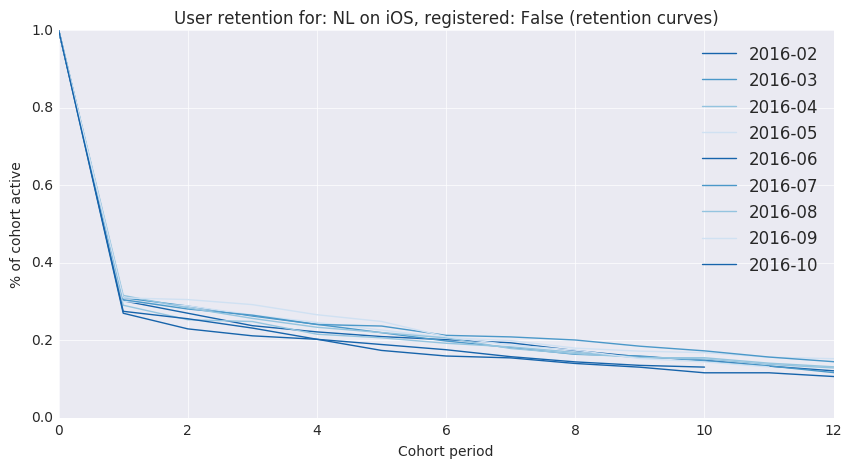

In [27]:
title = 'User retention for: ' + country_value + ' on ' + platform_value +', registered: ' + str(user_registered_value) 

fig, ax = plt.subplots(figsize=(10,5))

seq_col_brew = sns.cubehelix_palette(15, start=2, reverse=False)
sns.set_palette(seq_col_brew)

for i in range(0, len(user_retention.columns)):
    plt.plot(user_retention[user_retention.columns[i]])

plt.title(title + ' (retention curves)')
# plt.imshow(g, cmap='Blues',  interpolation='nearest')
plt.xlabel("Cohort period")
plt.ylabel("% of cohort active")
ax.legend()
plt.xlim(0, 12)
plt.show()

### 3.2. Heatmap

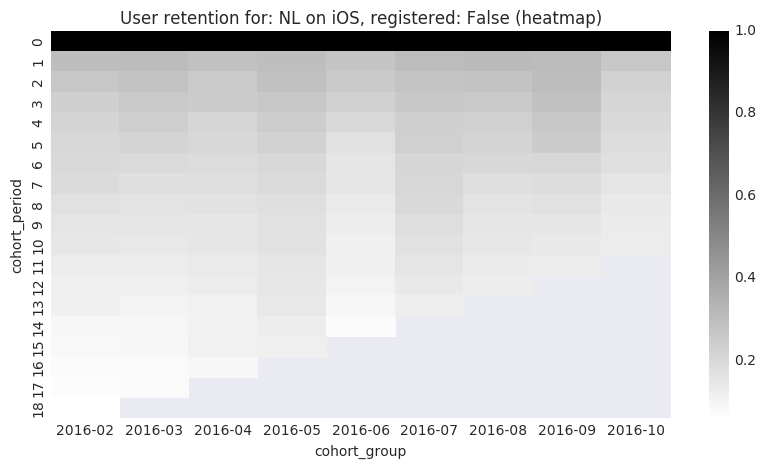

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(user_retention, cmap="binary", ax=ax)
ax.set_title(title + ' (heatmap)')
plt.show()

## Interactive visualization

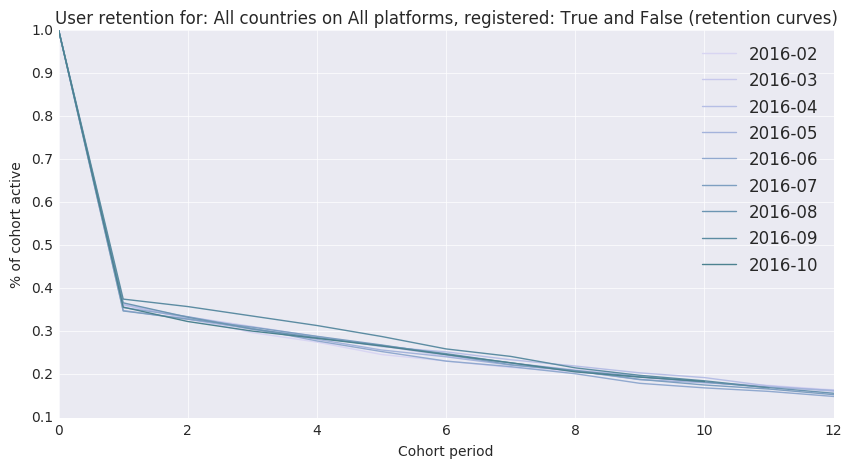

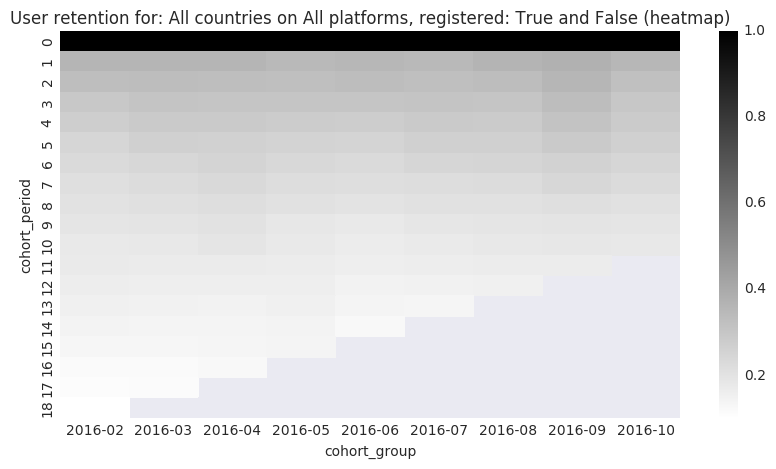

In [29]:
def func_cohort_analysis(country, platform, user_registered):
    
    # segmenting users
    segmented_user_events_df = segmenting(all_user_data_df.copy(), country=country, platform=platform, user_registered=user_registered)
    
    # building cohorts
    user_retention = build_cohorts(segmented_user_events_df)
    
    

    # visualization 1 - retention curve
    
    title = 'User retention for: ' + country + ' on ' + platform +', registered: ' + str(user_registered) 

    fig, ax = plt.subplots(figsize=(10,5))

    seq_col_brew = sns.cubehelix_palette(15, start=2, reverse=False)
    sns.set_palette(seq_col_brew)

    for i in range(0, len(user_retention.columns)):
        plt.plot(user_retention[user_retention.columns[i]])

    plt.title(title + ' (retention curves)')
    # plt.imshow(g, cmap='Blues',  interpolation='nearest')
    plt.xlabel("Cohort period")
    plt.ylabel("% of cohort active")
    ax.legend()
    plt.xlim(0, 12)
    plt.show()
    
    
    
    # visualization 2 - heatmap
    
    fig, ax = plt.subplots(figsize=(10,5))
    sns.heatmap(user_retention, cmap="binary", ax=ax)
    ax.set_title(title + ' (heatmap)')
    plt.show()
    

    
    
interact(func_cohort_analysis, country=country_values , platform=platform_values, user_registered=user_registered_values);